## Packages installation

In [ ]:
!pip install pykan

In [ ]:
from collections import deque, namedtuple
import random
import torch
from kan import *
from tqdm import tqdm
import matplotlib.pyplot as plt
import gym
import numpy as np
import matplotlib
import yaml

## Utilization

In [ ]:
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

class ReplayBuffer_dict:
    def __init__(self, max_size = 10000) -> None:
        self.buffer = deque([], maxlen = max_size)

    def push(self, *args):
        self.buffer.append(Transition(*args))

    def sample(self, BS_train: int, BS_test = 0):
        """
        randomly sample few sets for train and test, convert these elementwise deque into attribute-wise,
        then output as dict
        """
        sample_deque = random.sample(self.buffer, BS_train + BS_test)    #return a sublist with random sampled elements

        batch = Transition(*zip(*sample_deque))
        state_batch = torch.cat(batch.state)
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)

        non_final_mask_batch = torch.tensor(tuple(
            map(lambda next_s: next_s is not None, batch.next_state)
            ), dtype = torch.bool, device = device)
        non_final_next_state_batch = torch.tensor(torch.cat([next_s for next_s in batch.next_state if next_s is not None]),
                                      dtype = torch.float32, device = device)

        return state_batch, action_batch, reward_batch, non_final_mask_batch, non_final_next_state_batch

    """
    def target_generate(self, target_kan, non_final_next_state_batch) -> torch.tensor:
        next_q_values = torch.zeros()
        with torch.no_grad():
            next_q_values = target_kan(non_final_next_state_batch).max(1).values
        return
    """
    def __len__(self):
        return len(self.buffer)

def target_load_weights(policy_model, target_model, TAU = 1):
    """
    Update the target model towards policy model with TAU percentage
    """
    policy_model_state_dict = policy_model.state_dict()
    target_model_state_dict = target_model.state_dict()
    for key in policy_model_state_dict:
        target_model_state_dict[key] = TAU * policy_model_state_dict[key] + (1 - TAU) * target_model_state_dict[key]
    target_model.load_state_dict(target_model_state_dict)

    return target_model

def explore_or_exploit_action(explore_rate, state):
    randN = random.random()
    if randN < explore_rate:
        action = env.action_space.sample()
        return torch.tensor([[action]], dtype = torch.int64, device = device)
    else:
        return torch.tensor(policy_model(state), dtype = torch.int64, device = device).max(1).indices.view(1,1)

is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display
def plot_reward(cumulated_reward_list, show_result = False):
  plt.figure(1)
  plt.clf()
  plt.xlabel('episode index')
  plt.ylabel('cumulated reward')
  plt.plot(cumulated_reward_list)
  plt.pause(1)  # pause a bit so that plots are updated
  if is_ipython:
    if not show_result:
      display.display(plt.gcf())
      display.clear_output(wait=True)
    else:
      display.display(plt.gcf())

## Configuration

In [ ]:
env = gym.make('CartPole-v1')
lr = 1e-4
bs = 32

trade_off_const = 1 #initial value of exploration-exploitation ratio
trade_off_decay = 0.995
trad_off_min = 0.01
discount_factor = 0.99
TAU = 0.005
episodes = 200
steps = 500

#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')  #on colab, the KAN cannot be loaded on graphic card, unkown for the locals

policy_model = KAN(width = [4,4,2], grid = 5, k = 3)
target_model = KAN(width = [4,4,2], grid = 5, k = 3)
target_model = target_load_weights(policy_model, target_model)   #make sure policy and target model start from the same value

policy_model = policy_model.to(device)
target_model = target_model.to(device)

criterion = torch.nn.MSELoss()
opt = torch.optim.Adam(policy_model.parameters(), lr = lr)

loss = 0

## Tuning

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
Loss of last step in each episode: 0, Ep:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
Loss of last step in each episode: 0.0; Cumulated reward: 15; Config: 5.yml in #0:   0%|      

{'bs': 16, 'lr': 0.0001, 'node': 8, 'num_of_layers': 3}


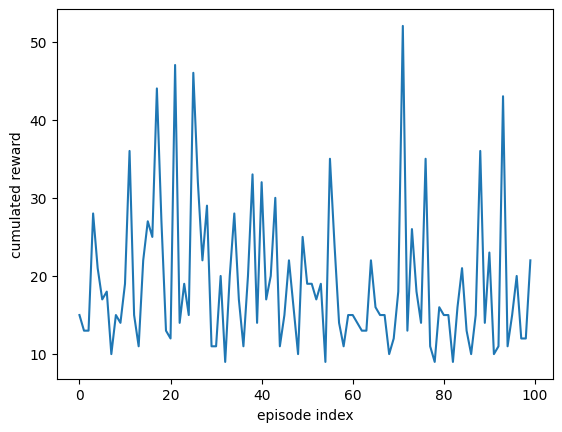

<Figure size 640x480 with 0 Axes>


Loss of last step in each episode: 0, Ep:   0%|          | 0/100 [00:00<?, ?it/s]
Loss of last step in each episode: 0.136; Cumulated reward: 12; Config: 5.yml in #0:  99%|█████████▉| 99/100 [01:16<00:00,  1.29it/s]

Loss of last step in each episode: 0.05; Cumulated reward: 13; Config: 1.yml in #1:   1%|          | 1/100 [00:00<00:24,  3.98it/s]
Loss of last step in each episode: 0.05; Cumulated reward: 13; Config: 1.yml in #1:   2%|▏         | 2/100 [00:00<00:12,  7.76it/s]
Loss of last step in each episode: 0.01; Cumulated reward: 11; Config: 1.yml in #1:   2%|▏         | 2/100 [00:00<00:12,  7.76it/s]
Loss of last step in each episode: 0.01; Cumulated reward: 11; Config: 1.yml in #1:   3%|▎         | 3/100 [00:00<00:12,  7.74it/s]
Loss of last step in each episode: 0.024; Cumulated reward: 12; Config: 1.yml in #1:   3%|▎         | 3/100 [00:00<00:12,  7.74it/s]
Loss of last step in each episode: 0.024; Cumulated reward: 12; Config: 1.yml in #1:   4%|▍         | 4/100 [00:00<00:12,

{'bs': 16, 'lr': 0.01, 'node': 8, 'num_of_layers': 2}


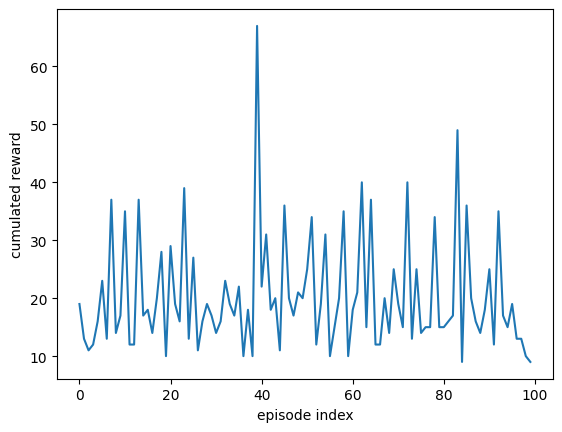

<Figure size 640x480 with 0 Axes>

Loss of last step in each episode: 0.002; Cumulated reward: 10; Config: 1.yml in #1:  99%|█████████▉| 99/100 [00:24<00:00,  3.98it/s]
Loss of last step in each episode: 0.008; Cumulated reward: 12; Config: 6.yml in #2:  99%|█████████▉| 99/100 [02:39<00:01,  1.14s/it]

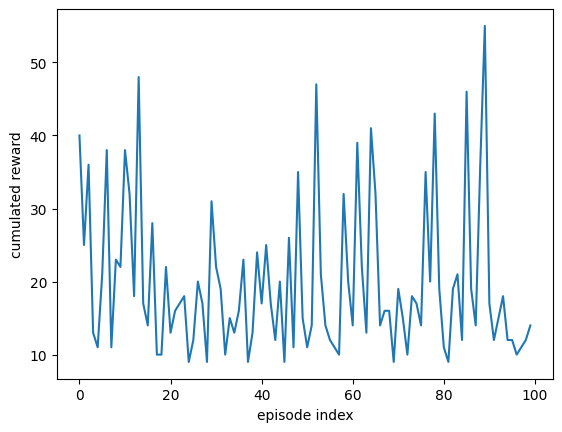

<Figure size 640x480 with 0 Axes>


Loss of last step in each episode: 0, Ep:   0%|          | 0/100 [00:00<?, ?it/s]
Loss of last step in each episode: 0.008; Cumulated reward: 12; Config: 6.yml in #2:  99%|█████████▉| 99/100 [02:41<00:01,  1.63s/it]

Loss of last step in each episode: 0.656; Cumulated reward: 15; Config: 4.yml in #3:   1%|          | 1/100 [00:00<00:20,  4.85it/s]
Loss of last step in each episode: 0.656; Cumulated reward: 15; Config: 4.yml in #3:   2%|▏         | 2/100 [00:00<00:10,  9.32it/s]
Loss of last step in each episode: 0.605; Cumulated reward: 12; Config: 4.yml in #3:   2%|▏         | 2/100 [00:00<00:10,  9.32it/s]
Loss of last step in each episode: 0.605; Cumulated reward: 12; Config: 4.yml in #3:   3%|▎         | 3/100 [00:00<00:11,  8.42it/s]
Loss of last step in each episode: 0.696; Cumulated reward: 13; Config: 4.yml in #3:   3%|▎         | 3/100 [00:00<00:11,  8.42it/s]
Loss of last step in each episode: 0.696; Cumulated reward: 13; Config: 4.yml in #3:   4%|▍         | 4/100 [00:00<00

{'bs': 16, 'lr': 0.0001, 'node': 8, 'num_of_layers': 2}


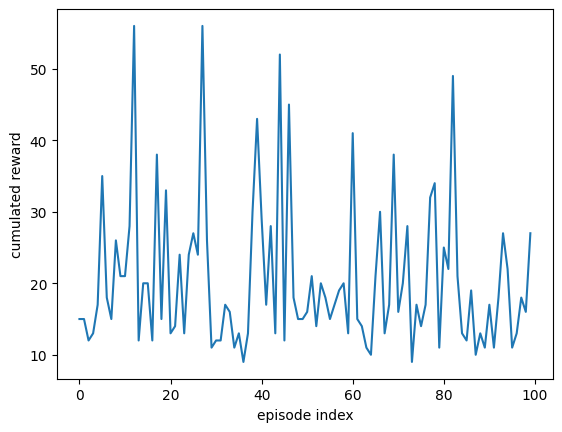

<Figure size 640x480 with 0 Axes>

Loss of last step in each episode: 0.388; Cumulated reward: 16; Config: 4.yml in #3:  99%|█████████▉| 99/100 [00:26<00:00,  3.71it/s]
Loss of last step in each episode: 0.001; Cumulated reward: 13; Config: 3.yml in #4:  99%|█████████▉| 99/100 [02:32<00:01,  1.23s/it]

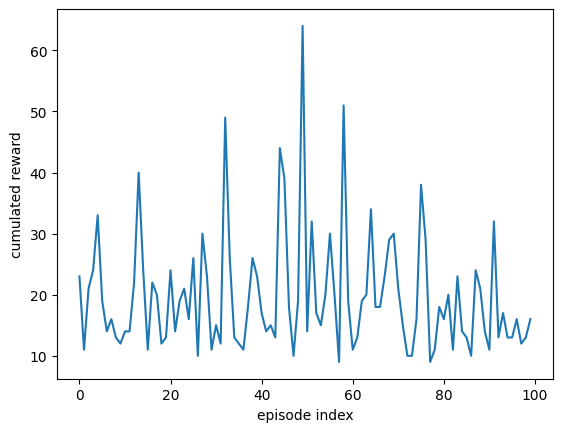

<Figure size 640x480 with 0 Axes>


Loss of last step in each episode: 0.001; Cumulated reward: 13; Config: 3.yml in #4:  99%|█████████▉| 99/100 [02:35<00:01,  1.57s/it]

Loss of last step in each episode: 0.031; Cumulated reward: 24; Config: 2.yml in #5:   0%|          | 0/100 [00:00<?, ?it/s]
Loss of last step in each episode: 0.031; Cumulated reward: 24; Config: 2.yml in #5:   1%|          | 1/100 [00:00<00:35,  2.80it/s]
Loss of last step in each episode: 0.0; Cumulated reward: 76; Config: 2.yml in #5:   1%|          | 1/100 [00:02<00:35,  2.80it/s]  
Loss of last step in each episode: 0.0; Cumulated reward: 76; Config: 2.yml in #5:   2%|▏         | 2/100 [00:02<02:36,  1.59s/it]
Loss of last step in each episode: 0.0; Cumulated reward: 27; Config: 2.yml in #5:   2%|▏         | 2/100 [00:04<02:36,  1.59s/it]
Loss of last step in each episode: 0.0; Cumulated reward: 27; Config: 2.yml in #5:   3%|▎         | 3/100 [00:04<02:17,  1.42s/it]
Loss of last step in each episode: 0.0; Cumulated reward: 11; Config: 2.yml in #

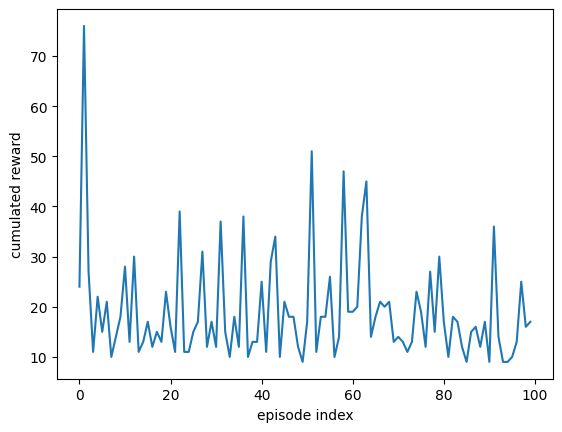

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [ ]:
env = gym.make('CartPole-v1')

max_ave_cumulated_reward = 0

folder_path = '/content/config'
file_names = os.listdir(folder_path)
for j,file_name in enumerate(file_names):

    trade_off_const = 1 #initial value of exploration-exploitation ratio
    trade_off_decay = 0.995
    trad_off_min = 0.01
    discount_factor = 0.99
    TAU = 0.005
    episodes = 100
    steps = 500

    file_path = os.path.join(folder_path, file_name)
    with open(file_path, 'r') as file:
        config = yaml.full_load(file)
    bs = config['bs']
    lr = config['lr']
    layer_node = config['node']

    if config['num_of_layers'] == 2:
        layer_list = [4, 2]
    elif config['num_of_layers'] == 3:
        layer_list = [4, layer_node, 2]
    elif config['num_of_layers'] == 4:
        layer_list = [4, layer_node, layer_node, 2]

    policy_model = KAN(width = layer_list, grid = 5, k = 3)
    target_model = KAN(width = layer_list, grid = 5, k = 3)
    target_model = target_load_weights(policy_model, target_model)   #make sure policy and target model start from the same value

    criterion = torch.nn.SmoothL1Loss()
    opt = torch.optim.Adam(policy_model.parameters(), lr = lr)

    loss = 0

    cumulated_reward_list = []
    cumulated_reward = 0

    replaybuffer = ReplayBuffer_dict()

    for ep in range(episodes):
        state = env.reset()
        state = torch.tensor(state[np.newaxis,:], dtype = torch.float, device=device)


        if ep == 0:
          pbar = tqdm(total=episodes, desc=f'Loss of last step in each episode: {loss}, Ep')
        else:
          pbar.set_description(desc = f'Loss of last step in each episode: {round(float(loss), 3)}; Cumulated reward: {cumulated_reward}; Config: {file_name} in #{j}')
          pbar.update()

        cumulated_reward = 0

        for step in range(steps):

            action = explore_or_exploit_action(explore_rate = trade_off_const, state = state)

            next_state, reward, done, _ = env.step(int(action)) #different versions of gym have different numbers of output

            next_state = torch.tensor(next_state, dtype = torch.float, device = device).unsqueeze(0)
            reward = torch.tensor([reward], dtype = torch.float, device = device)

            replaybuffer.push(state, action, next_state, reward)

            state = next_state  #update state

            if len(replaybuffer) < bs:  #store enough data for batch extraction
                cumulated_reward += int(reward)
                if done == True:
                    cumulated_reward_list.append(cumulated_reward)
                    break
                continue

            state_batch, action_batch, reward_batch, non_final_mask_batch, non_final_next_state_batch = replaybuffer.sample(bs)

            next_q_values = torch.zeros(bs, device = device)
            with torch.no_grad():
                next_q_values[non_final_mask_batch] = target_model(non_final_next_state_batch).max(1).values

            target_q_values = reward + discount_factor * next_q_values
            target_q_values = target_q_values.unsqueeze(1)  #make the dimsion elementwise to match with current_q_values's shape

            current_q_values = policy_model(state_batch).gather(1, action_batch)    #only use the action contributed tensor (assume generated by the policy model) for gradient updates

            loss = criterion(current_q_values, target_q_values)

            cumulated_reward += int(reward) #although the model is learning on randomly sampled cases, the current reward is made based on the learning model

            target_model = target_load_weights(policy_model, target_model, TAU= TAU)

            if done == True:
              cumulated_reward_list.append(int(cumulated_reward))
              trade_off_const = max(trad_off_min, trade_off_decay * trade_off_const)  #update possibility of exploration/exploitation
              #plot_reward(cumulated_reward_list)

              break

            opt.zero_grad()
            loss.backward()
            #torch.nn.utils.clip_grad_value_(policy_model.parameters(), 100)
            opt.step()

    if max_ave_cumulated_reward < np.mean(cumulated_reward_list):
      max_ave_cumulated_reward = np.mean(cumulated_reward_list)
      print(config)
    plot_reward(cumulated_reward_list, True)

In [ ]:
print(policy_model.biases[0].weight)
print(target_model.biases[0].weight)
print(trade_off_const)

Parameter containing:
tensor([[ 0.0067,  0.0063,  0.0068,  0.0070,  0.0072, -0.0047,  0.0065, -0.0014,
          0.0066,  0.0071,  0.0063,  0.0070,  0.0066,  0.0058,  0.0066,  0.0068,
          0.0071,  0.0063,  0.0070,  0.0064,  0.0071,  0.0058,  0.0061,  0.0060,
          0.0080,  0.0079,  0.0060,  0.0067,  0.0069,  0.0064, -0.0013,  0.0066]],
       requires_grad=True)
Parameter containing:
tensor([[ 0.0018,  0.0017,  0.0017,  0.0018,  0.0018, -0.0012,  0.0017, -0.0009,
          0.0018,  0.0019,  0.0017,  0.0019,  0.0018,  0.0016,  0.0017,  0.0018,
          0.0019,  0.0017,  0.0019,  0.0017,  0.0019,  0.0016,  0.0017,  0.0017,
          0.0020,  0.0020,  0.0017,  0.0018,  0.0018,  0.0017,  0.0001,  0.0017]],
       requires_grad=True)
0.9752487531218751


In [ ]:
cumulated_reward

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


12

In [ ]:
a = [1,2,3,4]
np.mean(a)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


2.5

## Main

Loss of last step in each episode: 0, Ep:   0%|          | 0/200 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
Loss of last step in each episode: 0.0; Cumulated reward: 30;:   0%|          | 0/200 [00:00<?, ?it/s]<ipython-input-10-427f0b234f9e>:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  non_final_next_state_batch = torch.tensor(torch.cat([next_s for next_s in batch.next_state if next_s is not None]),
Loss of last step in each episode: 798104.875; Cumulated reward: 14;:  18%|█▊        | 36/200 [00:26<02:02,  1.34it/s]
Loss of last step in each episode: 98.859; Cumulated reward: 12;:   4%|▎         | 7/200 [00:02<01:02,  3.07it/s]<ipython-inp

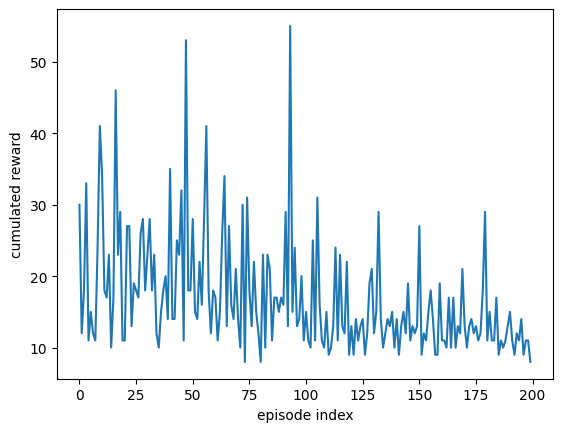

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [ ]:
cumulated_reward_list = []
cumulated_reward = 0

replaybuffer = ReplayBuffer_dict()

for ep in range(episodes):
    state = env.reset()
    state = torch.tensor(state[np.newaxis,:], dtype = torch.float, device=device)



    if ep == 0:
      pbar = tqdm(total=episodes, desc=f'Loss of last step in each episode: {loss}, Ep')
    else:
      pbar.set_description(desc = f'Loss of last step in each episode: {round(float(loss), 3)}; Cumulated reward: {cumulated_reward};')
      pbar.update()

    cumulated_reward = 0
    for step in range(steps):

        action = explore_or_exploit_action(explore_rate = trade_off_const, state = state)

        next_state, reward, done, _ = env.step(int(action)) #different versions of gym have different numbers of output

        next_state = torch.tensor(next_state, dtype = torch.float, device = device).unsqueeze(0)
        reward = torch.tensor([reward], dtype = torch.float, device = device)

        replaybuffer.push(state, action, next_state, reward)

        state = next_state  #update state

        if len(replaybuffer) < bs:  #store enough data for batch extraction
            cumulated_reward += int(reward)
            if done == True:
                cumulated_reward_list.append(cumulated_reward)
                break
            continue

        state_batch, action_batch, reward_batch, non_final_mask_batch, non_final_next_state_batch = replaybuffer.sample(bs)

        next_q_values = torch.zeros(bs, device = device)
        with torch.no_grad():
            next_q_values[non_final_mask_batch] = target_model(non_final_next_state_batch).max(1).values

        target_q_values = float(10)*reward_batch + discount_factor * next_q_values
        target_q_values = target_q_values.unsqueeze(1)  #make the dimsion elementwise to match with current_q_values's shape

        current_q_values = policy_model(state_batch).gather(1, action_batch)    #only use the action contributed tensor (assume generated by the policy model) for gradient updates

        loss = criterion(current_q_values, target_q_values)

        cumulated_reward += int(reward) #although the model is learning on randomly sampled cases, the current reward is made based on the learning model

        target_model = target_load_weights(policy_model, target_model, TAU= TAU)

        if done == True:
          cumulated_reward_list.append(int(cumulated_reward))
          trade_off_const = max(trad_off_min, trade_off_decay * trade_off_const)  #update possibility of exploration/exploitation
          #plot_reward(cumulated_reward_list)

          break

        opt.zero_grad()
        loss.backward()
        #torch.nn.utils.clip_grad_value_(policy_model.parameters(), 100)
        opt.step()

plot_reward(cumulated_reward_list, True)

In [ ]:
print(policy_model.biases[0].weight)
print(target_model.biases[0].weight)
print(trade_off_const)

Parameter containing:
tensor([[56.9075, 55.5687]], requires_grad=True)
Parameter containing:
tensor([[53.3382, 52.2031]], requires_grad=True)
0.3706551064126331


In [ ]:
print(target_q_values.view(bs))
print(current_q_values.view(bs))
error = current_q_values - next_q_values

tensor([23330.6953, 25424.6875, 22395.2227, 25405.2129, 25424.6875, 25426.8906,
        25430.6367, 25239.6172, 25356.7891, 25252.6211, 25356.9688, 25359.2656,
        21844.2285, 25350.9492, 23290.9004, 25367.3906, 25353.0547, 25431.3184,
        23851.5742, 25372.8848, 25400.1406, 25426.8887, 25364.9336, 25244.7969,
        24818.8281, 25418.5547, 25236.7891, 22625.9453, 25428.7422, 25414.8223,
        24626.1016, 24977.3906])
tensor([12435.4863, 14882.9932, 12337.7256, 14781.6602, 14869.8408, 14875.3867,
        13975.0762, 14828.1553, 13736.1279, 13453.3125, 13967.0146, 14040.1953,
        11473.6074, 14879.7607, 14124.8242, 14884.5088, 14015.8574, 14878.0820,
        13063.0322, 14886.0010, 13925.3105, 14859.0947, 14883.6973, 13980.8516,
        12154.8516, 13981.6318, 13974.4736, 13497.4766, 14881.9355, 14019.1572,
        13552.9883, 13799.2627], grad_fn=<ViewBackward0>)


### Model Saving

In [ ]:
torch.save(policy_model.state_dict(), 'DQN-KAN.state_dict')

## Evaluation

In [ ]:
import gym
import torch
import numpy as np

num_eval_episodes = 5
eval_reward_list = []

DQN_model = KAN(width = [4,16,16,2], grid = 5, k = 3)
checkpoint = torch.load('/content/DQN-KAN.state_dict')
DQN_model.load_state_dict(checkpoint)


for _ in range(num_eval_episodes):
  state = env.reset()
  state = torch.tensor(state[np.newaxis,:], dtype = torch.float32)
  eval_reward = 0

  for __ in range (600):
    action = int(torch.argmax(DQN_model(state)))
    next_state, reward, done, _ = env.step(action)

    eval_reward += reward
    state = torch.tensor(next_state[np.newaxis, :], dtype = torch.float32)

    if done:
      break
  eval_reward_list.append(eval_reward)

average_eval_reward = np.mean(eval_reward_list)
print(f'Cumulated reward list: {eval_reward_list}')
print(f'Average evaluation reward: {average_eval_reward}')

Cumulated reward list: [8.0, 9.0, 9.0, 9.0, 9.0]
Average evaluation reward: 8.8
